In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from styleframe import StyleFrame
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from collections.abc import Callable
from dataclasses import dataclass
import re
from scipy import stats

In [2]:
sns.set_theme(style="whitegrid")

# Mutation score

In [3]:
N_MUTANTS = {'total': 39}
N_MUTANTS_PER_CLASS = {'Tile': 24, 'Grid': 15}
N_MUTANTS_PER_MUTATOR = {'returns.BooleanFalseReturnValsMutator': 1, 'IncrementsMutator': 2, 'VoidMethodCallMutator': 2, 'returns.BooleanTrueReturnValsMutator': 7, 'ConditionalsBoundaryMutator': 1, 'returns.NullReturnValsMutator': 4, 'returns.EmptyObjectReturnValsMutator': 1, 'NegateConditionalsMutator': 10, 'MathMutator': 6, 'returns.PrimitiveReturnsMutator': 5}
N_MUTANTS_PER_METHOD = {'Tile.getNearestPower2': 2, 'Tile.getValue': 1, 'Tile.isMerged': 2, 'Tile.canMergeWith': 7, 'Tile.mergeWith': 5, 'Tile.toString': 1, 'Tile.equals': 6, 'Grid.getTile': 4, 'Grid.getRow': 1, 'Grid.getCol': 4, 'Grid.setTile': 2, 'Grid.getLength': 1, 'Grid.clearMerged': 3}
N_MUTANTS_ALL = {**N_MUTANTS, **N_MUTANTS_PER_CLASS, **N_MUTANTS_PER_METHOD}

In [4]:
def count_students(_df: pd.DataFrame):
    """Count the number of students for each part and group."""
    _df = _df.groupby(["group", "part", "id"]).sum()
    for part in (1, 2):
        for group in ("pit", "reneri"):
            print(f"[Part {part}] Students in {group} group : {len(_df.loc[(group, 2)])}")

In [5]:
def display_rmv_students(_df: pd.DataFrame, col: str):
    """Display all the students to remove because there is null values."""
    removed_students = _df[_df[col].isnull()]["id"]
    removed_students = sorted(list(set(removed_students)))
    removed_students = map(str, removed_students)
    print("Students " + ", ".join(removed_students) + " were removed.")

In [6]:
def filter_not_both_part(_df: pd.DataFrame, nb_duplicates: int = 2) -> pd.DataFrame:
    """Remove people that didn't do both part"""
    both_part_ids = [i for i, v in dict(_df["id"].value_counts()).items() if v == nb_duplicates]
    return _df[_df["id"].isin(both_part_ids)]

In [7]:
mutants_df = pd.read_csv("./data/mutants.csv")
mutants_df = mutants_df.drop(list(N_MUTANTS_PER_MUTATOR.keys()), axis=1)
count_students(mutants_df)

[Part 1] Students in pit group : 21
[Part 1] Students in reneri group : 22
[Part 2] Students in pit group : 21
[Part 2] Students in reneri group : 22


In [8]:
display_rmv_students(mutants_df, "total")

Students 2, 4, 9, 13, 16, 18, 20, 21, 22, 24, 26, 35 were removed.


In [9]:
mutants_df = mutants_df.dropna()
count_students(mutants_df)

[Part 1] Students in pit group : 18
[Part 1] Students in reneri group : 17
[Part 2] Students in pit group : 18
[Part 2] Students in reneri group : 17


In [10]:
mutants_df = filter_not_both_part(mutants_df)
count_students(mutants_df)

[Part 1] Students in pit group : 16
[Part 1] Students in reneri group : 15
[Part 2] Students in pit group : 16
[Part 2] Students in reneri group : 15


In [11]:
mutants_df = mutants_df.groupby(["group", "part", "id"]).sum()

In [12]:
@dataclass(frozen=True)
class ColWrappingInfo:
    file_name: str
    data: pd.DataFrame
    col_wrap: int = None
    legend: bool = True

def handle_odd_col_wrap(col_wrap:int, df: pd.DataFrame, col_name: str, file_name: str, names: List[str]) -> List[ColWrappingInfo]:
    if col_wrap is None or len(names) % col_wrap == 0:
        return [ColWrappingInfo(file_name=f'{file_name}', data=df[df[col_name].isin(names)], col_wrap=col_wrap)]
    nb_empty_cells = len(names) % col_wrap
    head_data = df[df[col_name].isin(names[:-nb_empty_cells])]
    tail_data = df[df[col_name].isin(names[-nb_empty_cells:])]
    return [
        ColWrappingInfo(
            file_name=f'{file_name}_head',
            data=head_data,
            col_wrap=col_wrap,
        ),
        ColWrappingInfo(
            file_name=f'{file_name}_tail',
            data=tail_data,
            col_wrap=nb_empty_cells,
            legend=False,
        ),
    ]

In [13]:
def plot_box(df: pd.DataFrame, cols_to_filter: List[str], file_name: str, var_name:str=None, col_wrap: int=None):
    def plot_line(data, **kwargs):
        """Plot an horizontal line to show the total number of mutants in the block."""
        datum = next(iter(set(data)))
        plt.axhline(N_MUTANTS_ALL[datum], **kwargs)
    data = df[cols_to_filter].reset_index().copy()
    data = data.melt(["group", "part", "id"])
    data = data.rename({"value": "mutation score", "variable": var_name}, axis=1)
    infos = handle_odd_col_wrap(col_wrap, data, var_name, file_name, cols_to_filter)
    for info in infos:       
        grid = sns.catplot(x="group", y="mutation score", hue="part", col=var_name, kind="box", data=info.data, 
                             sharey=True, showmeans=True, col_wrap=info.col_wrap, sharex=False, legend_out=True, legend=info.legend)
        grid.map(plot_line, var_name, linewidth=3, alpha=0.5, color='r')
        grid.set(ylabel='mutation score', xlabel='group')
        grid.figure.savefig(f"output/images/mutants/{info.file_name}.pdf")

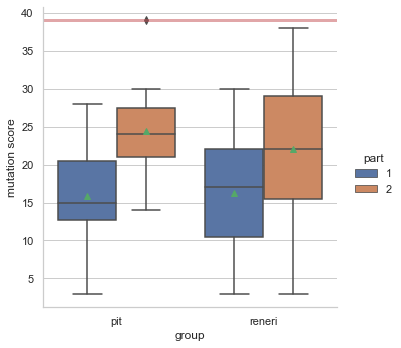

In [14]:
plot_box(mutants_df, ["total"], "total_mutants_boxplot")

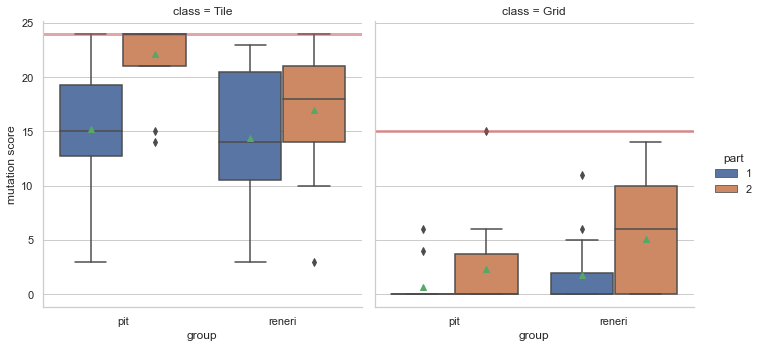

In [15]:
plot_box(mutants_df, ["Tile", "Grid"], "class_mutants_boxplot", "class")

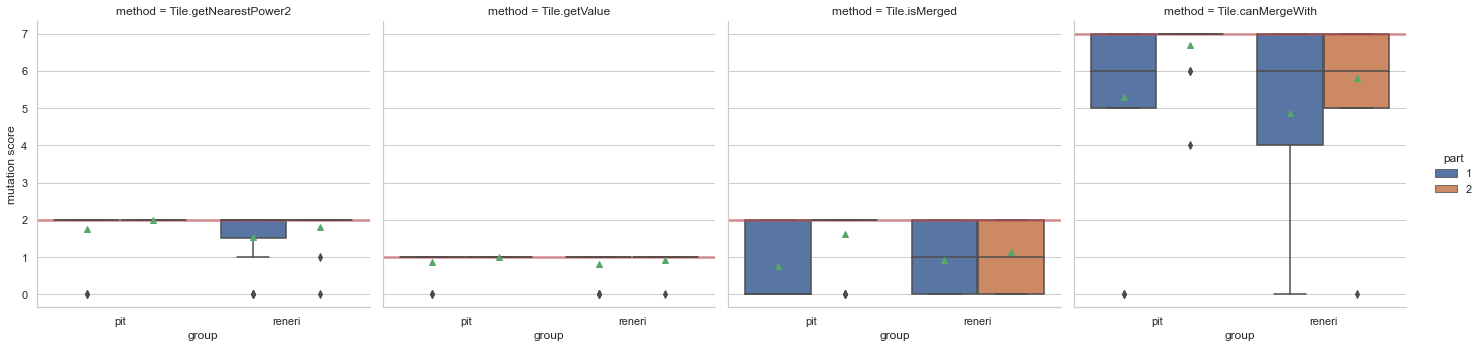

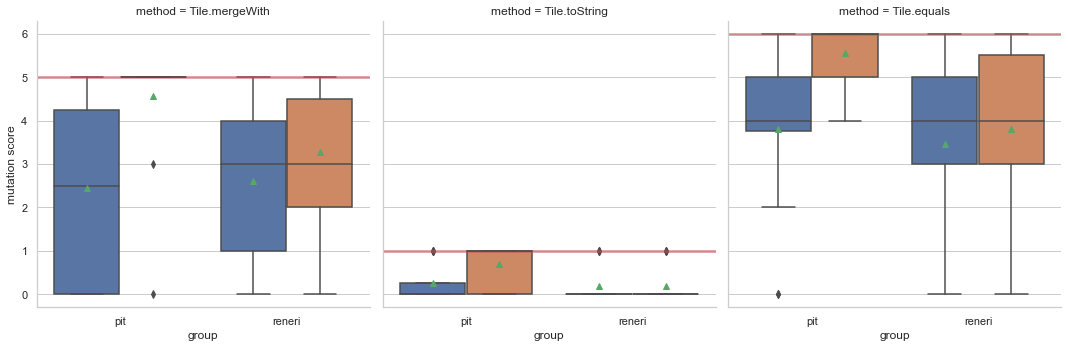

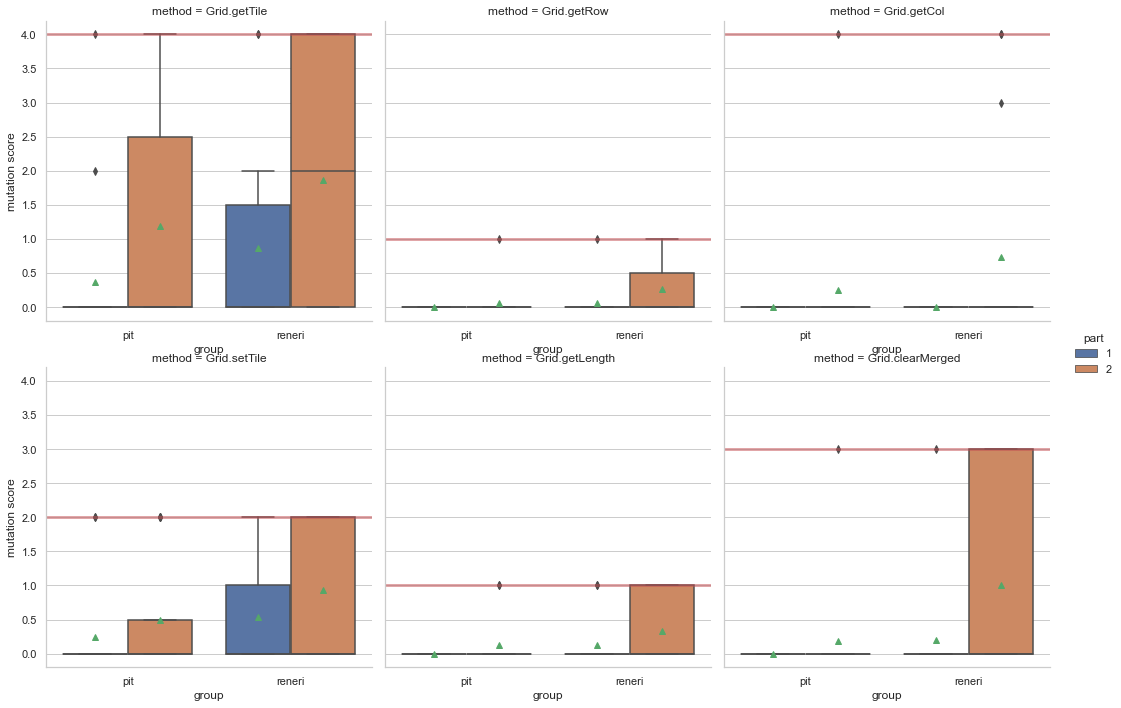

In [16]:
methods_cols = list(N_MUTANTS_PER_METHOD.keys())
for cls, col_wrap in (("Tile", 4), ("Grid", 3)):
    cls_methods_cols = [col for col in methods_cols if f"{cls}." in col]
    plot_box(mutants_df, cls_methods_cols, f"{cls.lower()}_methods_mutants_boxplot", "method", col_wrap=col_wrap)

In [17]:
def plot_violin(_df: pd.DataFrame, col: str, file_name: str):
    data = _df.reset_index().copy()
    ax = sns.violinplot(x="group", y=col, hue="part", 
                          data=data, split=True,  inner="quartile")
    ax.set(ylabel="mutation score")
    ax.get_figure().savefig(f"output/images/mutants/{file_name}.pdf", bbox_inches="tight")

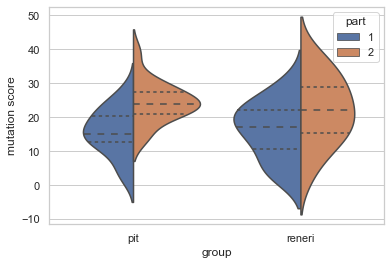

In [18]:
plot_violin(mutants_df, "total", "total_mutants_violinplot")

In [19]:
def format_cell(nb: float, nb_total: int, part: int) -> str:
    """Format a cell as a string showing the number of killed mutants out of the total number of mutants and the percentage."""
    perc = int(nb/nb_total*100)
    if part == "$\\Delta$":
        return f"{nb:+.1f} ({perc:+.0f}\\%)"
    return f"{nb:.1f}/{nb_total} ({perc:.0f}\\%)"

In [20]:
def to_latex_table(_df: pd.DataFrame, measure_name: str, value_name: str) -> str:
    label = f"tab:{measure_name}_{value_name}".lower().replace(' ', '_')
    caption = f"{measure_name} {value_name}"
    styler = _df.style.format_index(escape="latex", axis=0)
    column_format =  f"l{'c' * len(_df.columns)}"
    return styler.to_latex(
        column_format=column_format,
        hrules=True, label=label, caption=caption, multicol_align="c", environment="sidewaystable"
    ).replace("\\midrule", "\\cmidrule(lr){1-1} \\cmidrule(lr){2-4} \\cmidrule(lr){5-7}")

In [21]:
def compute_delta(_df: pd.DataFrame, sublevels: Tuple[any]=None) -> pd.DataFrame:
    if sublevels is None:
        sublevels = ()
    for group in ("pit", "reneri"):
        _df[(group, "$\\Delta$")+sublevels] = _df[(group, 2)+sublevels] - _df[(group, 1)+sublevels]
    for i in range(len(sublevels),-1,-1):
        _df = _df.sort_index(level=i, axis=1)
    return _df

In [22]:
MIDRULE = r"\n\\cmidrule(lr){1-1} \\cmidrule(lr){2-4} \\cmidrule(lr){5-7}"

In [23]:
def write_table_mutants(_df: pd.DataFrame, measure_name: str):
    file_name = f"killed_mutants_{measure_name}".lower().replace(' ', '_')
    _df = compute_delta(_df)
    for var_name, nb_total in N_MUTANTS_ALL.items():
        for group in ("pit", "reneri"):
            for part in (1, 2, "$\\Delta$"):
                nb = _df[(group, part)][var_name]
                _df.loc[var_name, (group, part)] = format_cell(nb, nb_total, part)
    _df = _df.rename({"total": "Total"})
    _df.columns.names = ["\\textbf{Group}", "\\textbf{Part}"]
    latex_table = to_latex_table(_df, measure_name, "Number of Killed Mutants")
    latex_table = re.sub(r"(?=\nTile )", MIDRULE, latex_table)
    latex_table = re.sub(r"(?=\nTile.getNearestPower2)", MIDRULE, latex_table)
    latex_table = re.sub(r"(?=\\caption)", r"\\centering\n", latex_table)
    with open(f"output/tables/mutants/{file_name}.tex", "w") as f:
        f.write(latex_table)

In [24]:
grouped_mutants_df = mutants_df.groupby(["group", "part"])
avg_mutants_df = grouped_mutants_df.mean().transpose()
std_mutants_df = grouped_mutants_df.std().transpose()
median_mutants_df = grouped_mutants_df.median().transpose()
q1_mutants_df = grouped_mutants_df.quantile(0.25).transpose()
q3_mutants_df = grouped_mutants_df.quantile(0.75).transpose()
iqr_mutants_df = q3_mutants_df - q1_mutants_df

In [25]:
write_table_mutants(avg_mutants_df, "Average"),
write_table_mutants(std_mutants_df, "Standard Deviation"),
write_table_mutants(median_mutants_df, "Median"),
write_table_mutants(q1_mutants_df, "First Quartile"),
write_table_mutants(q3_mutants_df, "Third Quartile"),
write_table_mutants(iqr_mutants_df, "Interquartile Range")

In [26]:
@dataclass(frozen=True)
class GroupStats:
    mean: float
    std: float
    size: int
    values: List[float]
        
    def __sub__(self, b):
        assert self.size == b.size
        return GroupStats(
            mean=self.mean-b.mean,
            std=self.std-b.std,
            size=self.size,
            values=self.values-b.values
        )
        

# https://en.wikipedia.org/wiki/Pooled_variance
def pooled_variance(group1: GroupStats, group2: GroupStats) -> float:
    """
    Estimate common variance between two groups with similar variance.
    """
    assert 0.5 <= (group1.std / group2.std ) <= 2
    numerator = (group1.std ** 2) * (group1.size - 1) + (group2.std ** 2) * (group2.size - 1)
    denominator = group1.size + group2.size - 2
    return numerator / denominator

# https://en.wikipedia.org/wiki/Effect_size#Cohen's_d
def cohend(group1: GroupStats, group2: GroupStats) -> float:
    """Compute the difference between two means divided by a standard deviation"""
    return abs(group1.mean - group2.mean) / (pooled_variance(group1, group2)**0.5)

In [27]:
from scipy.stats import rankdata

# https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65
def VD_A(control: List[float], treatment: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000
    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/
    """
    m = len(treatment)
    n = len(control)

    r = rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    return(2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

def interpret_vda(vda: float):
    diff = abs(0.5 - vda)
    if diff < 0.06:
        return "negligible"
    if diff < 0.14:
        return "small"
    if diff < 0.21:
        return "medium"
    return "large"

In [28]:
mutants_values = {
    (scope, group, part): np.asarray(mutants_df[scope].loc[(group, part)])
    for group in ("pit", "reneri")
    for part in (1, 2)
    for scope in ("total", "Grid", "Tile")
}

mutants_values = {
    **mutants_values,
    **{
        (scope, group, "delta"): mutants_values[(scope, group, 2)] - mutants_values[(scope, group, 1)]
        for group in ("pit", "reneri")
        for scope in ("total", "Grid", "Tile")
    }
}

In [29]:
def show_pvalue(p: float) -> str:
    if p < 0.001:
        return "p<.001"
    return 'p=' + f'{p:.3f}'.lstrip('0') 


def show_vda(control: np.ndarray, treatment: np.ndarray):
    vda = VD_A(list(control), list(treatment))
    effect_size = r"\textit{%s}" % interpret_vda(vda)
    return r"with a %s effect size, $\vad=%.2f$" % (effect_size, vda)

def independent_test(control: np.ndarray, treatment: np.ndarray, alternative="two-sided"):
    u = stats.mannwhitneyu(control, treatment, alternative=alternative)
    text = f"$U={u.statistic:.2f}$, ${show_pvalue(u.pvalue)}$, "
    print(text + show_vda(control, treatment))
        

def rel_test(control: np.ndarray, treatment: np.ndarray, alternative="two-sided"):
    w = stats.wilcoxon(control, treatment, alternative=alternative)
    text = f"$W={w.statistic:.2f}$, ${show_pvalue(w.pvalue)}$, "
    print(text + show_vda(control, treatment))

In [30]:
rel_test(mutants_values[("total", "pit", 1)], mutants_values[("total", "pit", 2)], "less")
rel_test(mutants_values[("total", "reneri", 1)], mutants_values[("total", "reneri", 2)], "less")
independent_test(mutants_values[("total", "pit", 2)], mutants_values[("total", "reneri", 2)])
independent_test(mutants_values[("total", "pit", "delta")], mutants_values[("total", "reneri", "delta")], "greater")

$W=0.00$, $p<.001$, with a \textit{large} effect size, $\vad=0.84$
$W=0.00$, $p=.001$, with a \textit{medium} effect size, $\vad=0.66$
$U=136.50$, $p=.526$, with a \textit{small} effect size, $\vad=0.43$
$U=160.50$, $p=.057$, with a \textit{medium} effect size, $\vad=0.33$


c:\users\msi-gaming\appdata\local\pypoetry\cache\virtualenvs\données-oojr5lt1-py3.9\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning:Exact p-value calculation does not work if there are ties. Switching to normal approximation.


In [31]:
rel_test(mutants_values[("Tile", "pit", 1)], mutants_values[("Tile", "pit", 2)])
rel_test(mutants_values[("Tile", "reneri", 1)], mutants_values[("Tile", "reneri", 2)])
independent_test(mutants_values[("Tile", "pit", 2)], mutants_values[("Tile", "reneri", 2)], "greater")
independent_test(mutants_values[("Tile", "pit", "delta")], mutants_values[("Tile", "reneri", "delta")], "greater")

$W=0.00$, $p<.001$, with a \textit{large} effect size, $\vad=0.84$
$W=0.00$, $p=.008$, with a \textit{small} effect size, $\vad=0.60$
$U=193.50$, $p=.002$, with a \textit{large} effect size, $\vad=0.19$
$U=182.00$, $p=.007$, with a \textit{large} effect size, $\vad=0.24$


c:\users\msi-gaming\appdata\local\pypoetry\cache\virtualenvs\données-oojr5lt1-py3.9\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning:Sample size too small for normal approximation.


In [32]:
rel_test(mutants_values[("Grid", "pit", 1)], mutants_values[("Grid", "pit", 2)])
rel_test(mutants_values[("Grid", "reneri", 1)], mutants_values[("Grid", "reneri", 2)])
independent_test(mutants_values[("Grid", "pit", 2)], mutants_values[("Grid", "reneri", 2)], "less")
independent_test(mutants_values[("Grid", "pit", "delta")], mutants_values[("Grid", "reneri", "delta")], "less")

$W=0.00$, $p=.043$, with a \textit{small} effect size, $\vad=0.63$
$W=0.00$, $p=.027$, with a \textit{medium} effect size, $\vad=0.64$
$U=88.00$, $p=.086$, with a \textit{small} effect size, $\vad=0.63$
$U=103.00$, $p=.223$, with a \textit{small} effect size, $\vad=0.57$


# Coverage

In [33]:
coverage_df = pd.read_csv("./data/coverage.csv")
coverage_df = coverage_df.set_index(["group",  "class", "part"]).sort_index()
count_students(coverage_df)

[Part 1] Students in pit group : 21
[Part 1] Students in reneri group : 22
[Part 2] Students in pit group : 21
[Part 2] Students in reneri group : 22


In [34]:
display_rmv_students(coverage_df, "instruction_missed")

Students 2, 4, 9, 13, 16, 18, 20, 21, 22, 24, 26, 35 were removed.


In [35]:
coverage_df = coverage_df.dropna()
count_students(coverage_df)

[Part 1] Students in pit group : 18
[Part 1] Students in reneri group : 17
[Part 2] Students in pit group : 18
[Part 2] Students in reneri group : 17


In [36]:
coverage_df = filter_not_both_part(coverage_df, 4)
count_students(coverage_df)

[Part 1] Students in pit group : 16
[Part 1] Students in reneri group : 15
[Part 2] Students in pit group : 16
[Part 2] Students in reneri group : 15


In [37]:
missed_columns = coverage_df.columns.str.endswith("_missed")
covered_columns = coverage_df.columns.str.endswith("_covered")
for missed, covered in zip(coverage_df.columns[missed_columns], coverage_df.columns[covered_columns]):
    name = missed.replace("_missed", "")
    assert name == covered.replace("_covered", "")
    coverage_df[f"{name} coverage"] = coverage_df[covered]/(coverage_df[covered]+coverage_df[missed])

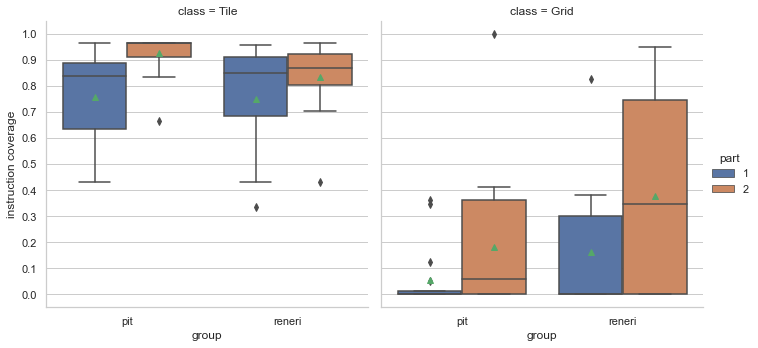

In [38]:
data = coverage_df.sort_values(by=['group']).reset_index()
coverage_plot = sns.catplot(
    x="group", y="instruction coverage", hue="part", col="class", kind="box", data=data, col_order=["Tile", "Grid"], showmeans=True
)
_ = plt.yticks(np.arange(0, 1.1, 0.1))
coverage_plot.figure.savefig("output/images/coverage/coverage_plot.pdf")

In [39]:
c = coverage_df.drop(["id"], axis=1)
mean_coverage_df = c.groupby(["group", "part", "class"]).mean()
std_coverage_df = c.groupby(["group", "part", "class"]).std()

In [40]:
N_INSTRUCTIONS = {"Grid": 121, "Tile": 114}

In [41]:
def write_table_coverage(_df: pd.DataFrame, measure_name: str):
    file_name = f"instruction_coverage_{measure_name}".lower().replace(' ', '_')
    _df = _df.filter(["group", 'part', 'class', "instruction_covered"])
    _df = _df.transpose()
    for cls in ("Grid", "Tile"):
        _df = compute_delta(_df, sublevels=(cls,))
    for cls, nb_total in N_INSTRUCTIONS.items():
        for group in ("pit", "reneri"):
            for part in (1, 2, "$\\Delta$"):
                nb = _df[(group, part, cls)]["instruction_covered"]
                _df[(group, part, cls)] = format_cell(nb, nb_total, part)
    _df = _df.transpose()
    _df = _df.reset_index()
    _df = _df.pivot(index='class', columns=['group', 'part'], values="instruction_covered")
    _df = _df.sort_index(axis=1)
    _df = _df.reindex(["Tile", "Grid"])
    _df.columns.names = ["\\textbf{Group}", "\\textbf{Part}"]
    _df.index.name = None
    latex_table = to_latex_table(_df, measure_name, "Number of Instructions Covered")
    latex_table = re.sub(r"(?=\\caption)", r"\\centering\n", latex_table)
    with open(f"output/tables/coverage/{file_name}.tex", "w") as f:
        f.write(latex_table)

In [42]:
write_table_coverage(mean_coverage_df, "Average"),
write_table_coverage(std_coverage_df, "Standard Deviation")

In [43]:
coverage_values = {
    (scope, group, part): np.asarray(coverage_df.loc[(group, scope, part)]["instruction coverage"])
    for group in ("pit", "reneri")
    for part in (1, 2)
    for scope in ("Grid", "Tile")
}

coverage_values = {
    **coverage_values,
    **{
        (scope, group, "delta"): coverage_values[(scope, group, 2)] - coverage_values[(scope, group, 1)]
        for group in ("pit", "reneri")
        for scope in ("Grid", "Tile")
    }
}

In [44]:
independent_test(coverage_values[("Tile", "pit", "delta")], coverage_values[("Tile", "reneri", "delta")], "greater")

$U=171.50$, $p=.020$, with a \textit{large} effect size, $\vad=0.29$


In [45]:
independent_test(coverage_values[("Grid", "pit", "delta")], coverage_values[("Grid", "reneri", "delta")])

$U=112.50$, $p=.758$, with a \textit{negligible} effect size, $\vad=0.53$


# Reneri hints

In [46]:
HINT_TYPES = ["not_reached", "not_infected", "not_propagated", "not_revealed"]

In [47]:
hints_df = pd.read_csv("data/hints.csv")
count_students(hints_df)

[Part 1] Students in pit group : 21
[Part 1] Students in reneri group : 22
[Part 2] Students in pit group : 21
[Part 2] Students in reneri group : 22


In [48]:
display_rmv_students(hints_df, "not_reached")

Students 2, 4, 9, 13, 16, 18, 20, 21, 22, 24, 26, 35 were removed.


In [49]:
hints_df = hints_df.dropna()
count_students(hints_df)

[Part 1] Students in pit group : 18
[Part 1] Students in reneri group : 17
[Part 2] Students in pit group : 18
[Part 2] Students in reneri group : 17


In [50]:
hints_df = filter_not_both_part(hints_df)
count_students(hints_df)

[Part 1] Students in pit group : 16
[Part 1] Students in reneri group : 15
[Part 2] Students in pit group : 16
[Part 2] Students in reneri group : 15


In [51]:
hints_df

,id,group,part,not_reached,not_infected,not_propagated,not_revealed
0,1,reneri,1,16.0,0.0,0.0,0.0
1,1,reneri,2,15.0,0.0,0.0,0.0
4,3,reneri,1,12.0,1.0,0.0,0.0
5,3,reneri,2,9.0,0.0,0.0,0.0
8,5,reneri,1,11.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
81,41,pit,2,12.0,1.0,0.0,0.0
82,42,pit,1,15.0,0.0,0.0,0.0
83,42,pit,2,15.0,0.0,0.0,0.0
84,43,reneri,1,16.0,0.0,0.0,0.0


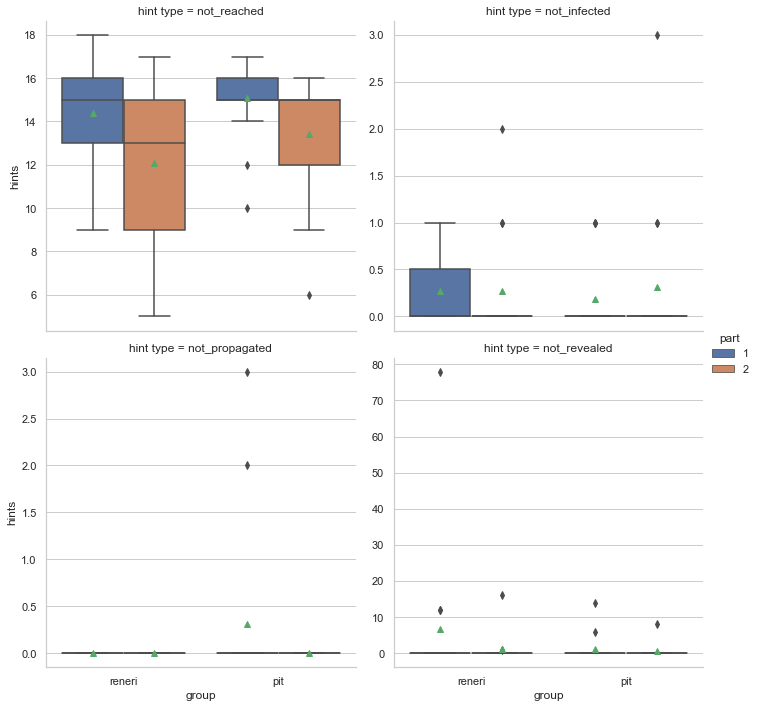

In [52]:
data = hints_df.copy()
data = data.melt(["id", "part", "group"])
data = data.rename({"value": "hints",  "variable": "hint type"}, axis=1)
grid = sns.catplot(x="group", y="hints", hue="part", col="hint type", kind="box", data=data, sharey=False, showmeans=True, col_wrap=2)
grid.figure.savefig("output/images/hints/hints_plot.pdf")

# Criteria

In [53]:
criteria_df = pd.read_csv("data/criteria.csv")
count_students(criteria_df)

[Part 1] Students in pit group : 21
[Part 1] Students in reneri group : 22
[Part 2] Students in pit group : 21
[Part 2] Students in reneri group : 22


In [54]:
for c in (f"c{i}" for i in range(1, 6)):
    print(c)
    criteria_df[c] = criteria_df[c].str.replace(",", ".")
    display_rmv_students(criteria_df, c)

c1
Students 2, 4, 8, 16 were removed.
c2
Students 2, 4, 8, 16 were removed.
c3
Students 2, 4, 8, 16 were removed.
c4
Students 1, 2, 4, 8, 16 were removed.
c5
Students 2, 4, 8, 11, 16, 32 were removed.


In [55]:
CRITERIA = {
    "c1": "Correctness (C1)",
    "c2": "Completeness (C2)",
    "c3": "Assertions (C3)",
    "c4": "Design (C4)",
    "c5": "Legibility (C5)"
}

In [56]:
criteria_melted_df = criteria_df.melt(["id", "group", "part"])

In [57]:
criteria_melted_df = criteria_melted_df[criteria_melted_df["value"].notnull()]
count_students(criteria_melted_df)

[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 20
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 20


In [58]:
criteria_melted_df["value"] = criteria_melted_df["value"].str.replace(",", ".").astype(float)
for c, name in CRITERIA.items():
    criteria_melted_df["variable"] = criteria_melted_df["variable"].str.replace(c, name)
# Filters out the criteria that have not been rated for both parties.
criteria_melted_df = pd.concat(
    [filter_not_both_part(criteria_melted_df[criteria_melted_df["variable"] == c]) for c in CRITERIA.values()]
)

In [59]:
for c in CRITERIA.values():
    print(c)
    count_students(criteria_melted_df[criteria_melted_df["variable"] == c])
    print()

Correctness (C1)
[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 19
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 19

Completeness (C2)
[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 19
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 19

Assertions (C3)
[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 19
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 19

Design (C4)
[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 18
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 18

Legibility (C5)
[Part 1] Students in pit group : 20
[Part 1] Students in reneri group : 17
[Part 2] Students in pit group : 20
[Part 2] Students in reneri group : 17



In [60]:
def plot_point(df: pd.DataFrame, names: List[str], file_name: str, col_wrap:int=None):
    df = df.rename({"value": "rating", "variable": "criterion"}, axis=1)
    df = df.sort_values(by=['group'])
    infos = handle_odd_col_wrap(col_wrap, df, "criterion", file_name, names)
    for info in infos:
        grid = sns.catplot(x="part", y="rating", col="criterion", hue="group", kind="point",
               col_wrap=info.col_wrap, data=info.data, dodge=True, estimator=np.mean, ci="sd", palette="bone",
              despine=False, legend=info.legend)
        grid.set(yticks=[1, 2, 3, 4], yticklabels=["1 (poor)", "2 (mediocre)", "3 (fair)", "4 (good)"])
        plt.tight_layout()
        grid.figure.savefig(f"output/images/criteria/{info.file_name}.pdf")

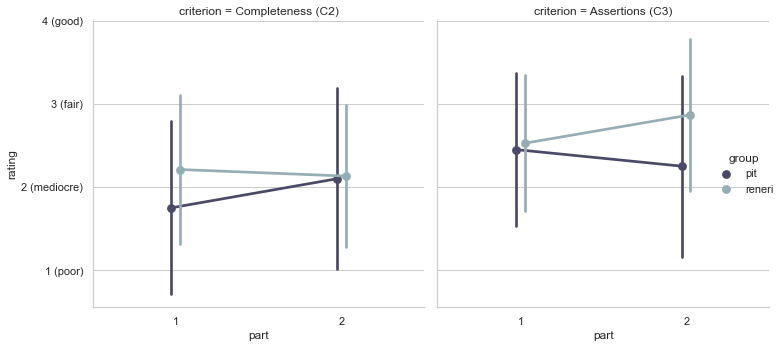

In [61]:
plot_point(criteria_melted_df, ["Completeness (C2)", "Assertions (C3)"], "criteria_plot")

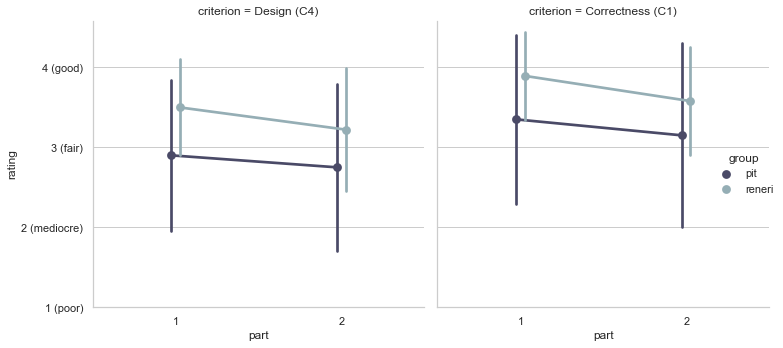

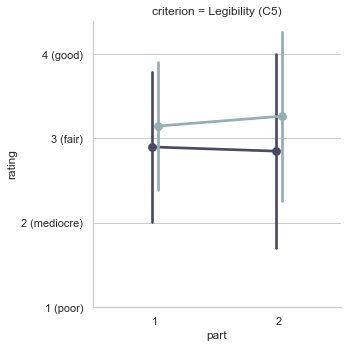

In [62]:
plot_point(criteria_melted_df, ["Correctness (C1)", "Design (C4)", "Legibility (C5)"], "criteria_plot_appendix", 2)

In [63]:
mean_criteria_df = criteria_melted_df.groupby(["variable", "group", "part"]).mean()[["value"]]
std_criteria_df = criteria_melted_df.groupby(["variable", "group", "part"]).std()[["value"]]

In [64]:
def write_table_criteria(_df: pd.DataFrame, measure_name: str):
    file_name = f"criteria_{measure_name}".lower().replace(' ', '_')
    _df = _df.reset_index()
    _df = _df.pivot(index='variable', columns=['group', 'part'], values="value")
    _df = _df.reindex(CRITERIA.values())
    _df = compute_delta(_df)
    _df = _df.applymap(lambda v: f"{v:+.2f}")
    _df.columns.names = ["\\textbf{Group}", "\\textbf{Part}"]
    _df.index.name = None
    latex_table = to_latex_table(_df, measure_name, "Rating")
    latex_table = re.sub(r"(?=\\caption)", r"\\centering\n", latex_table)
    with open(f"output/tables/criteria/{file_name}.tex", "w") as f:
        f.write(latex_table)

In [65]:
write_table_criteria(mean_criteria_df, "Average"),
write_table_criteria(std_criteria_df, "Standard Deviation")

# Questionnaire

In [66]:
from questions2latex  import write_table_questionaire

In [67]:
write_table_questionaire()